In [4]:
# Step 1: Set up Kaggle API for Google Colab
!pip install -q kaggle
from google.colab import files

# Upload your Kaggle API key (JSON file) here
files.upload()

# Move the kaggle.json file into the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
# Download the dataset from Kaggle (replace 'dataset-owner/dataset-name')
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [7]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [8]:
X = []
y = []

# Load images labeled "yes" for condition presence
os.chdir('/content/yes')
for i in tqdm(os.listdir()):
    # Check if the current item is a file to avoid reading directories
    if os.path.isfile(i):
        img = cv2.imread(i)
        # Check if the image was loaded successfully
        if img is not None:
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(1)  # Label 1 for "yes"
        else:
            print(f"Failed to load image: {i}")
# Load images labeled "no" for condition absence
os.chdir('/content/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append(0)  # Label 0 for "no"

# Convert X and y to numpy arrays and normalize image data
X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define custom Dataset class for PyTorch
class MedicalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create DataLoader for training and validation datasets
train_dataset = MedicalDataset(X_train, y_train, transform=transform)
val_dataset = MedicalDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

100%|██████████| 98/98 [00:00<00:00, 296.35it/s]


In [9]:
# Define transformations for classification and segmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
class MambaNet(nn.Module):
    def __init__(self, num_classes):
        super(MambaNet, self).__init__()

        # Shared feature extractor (ResNet backbone)
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the final fully connected layer

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(512, 2048, kernel_size=1),
            nn.Sigmoid()
        )

        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        # Segmentation head
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 1, kernel_size=1),  # Output for single-channel mask
            nn.Sigmoid()
        )

        # Restoration head
        self.restoration_head = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 3, kernel_size=1),  # Output RGB image
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        attention_weights = self.attention(features)
        attended_features = features * attention_weights

        # Classification output
        classification_output = attended_features.view(attended_features.size(0), -1)
        classification_output = self.classification_head(classification_output)

        # Segmentation output
        segmentation_output = self.segmentation_head(attended_features)

        # Restoration output

        return classification_output, segmentation_output, self.restoration_head(attended_features)

In [11]:
# Step 5: Instantiate Model and Move to GPU
# Get the number of unique classes from your labels
num_classes = len(np.unique(train_dataset.labels)) # Get unique classes from labels
model = MambaNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Step 6: Define Losses and Optimizer
classification_criterion = nn.CrossEntropyLoss()
segmentation_criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for segmentation mask
restoration_criterion = nn.MSELoss()  # MSE loss for image restoration

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Step 7: Training Loop
def train_model(num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            classification_output, segmentation_output, restoration_output = model(inputs)
            # Calculate losses
            classification_loss = classification_criterion(classification_output, labels)
            # Dummy segmentation and restoration targets
            segmentation_target = torch.zeros_like(segmentation_output)
            # Resize restoration target to match restoration output
            restoration_target = torch.nn.functional.interpolate(inputs, size=restoration_output.shape[2:], mode='bilinear', align_corners=False)
            segmentation_loss = segmentation_criterion(segmentation_output, segmentation_target)
            restoration_loss = restoration_criterion(restoration_output, restoration_target)

            # Combine losses
            total_loss = classification_loss + segmentation_loss + restoration_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(num_epochs=5)

print("Training complete!")

Epoch [1/5], Loss: 3.2739
Epoch [2/5], Loss: 3.0104
Epoch [3/5], Loss: 2.9640
Epoch [4/5], Loss: 2.9810
Epoch [5/5], Loss: 2.8386
Training complete!


In [14]:
class MedicalDataset(Dataset): # Assuming this is your dataset class
    def __init__(self, data_dir, transform=None):
        # ... your existing initialization code ...

        # Add a classes attribute
        self.classes = ['class1', 'class2', 'class3']  # Replace with your actual class names

    # ... your existing methods ...

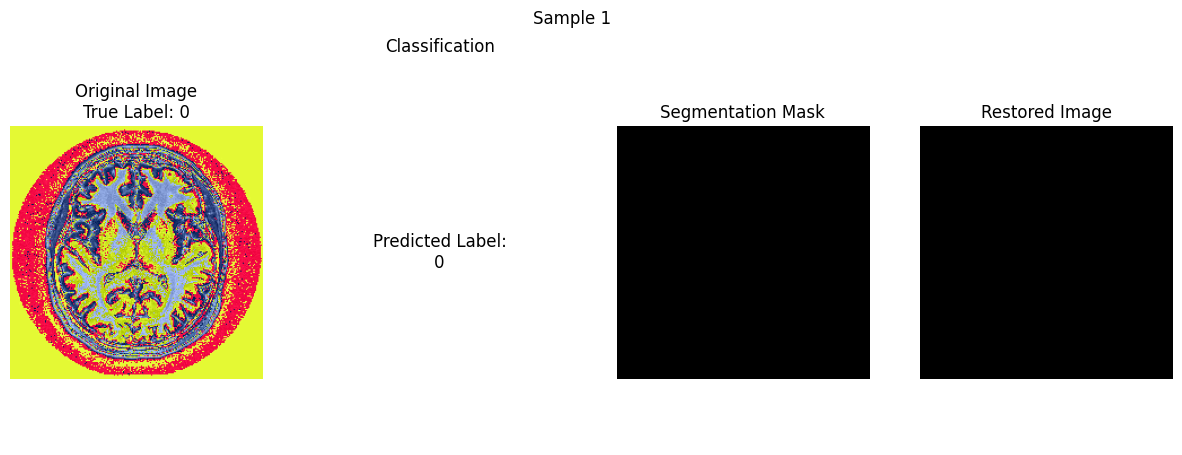

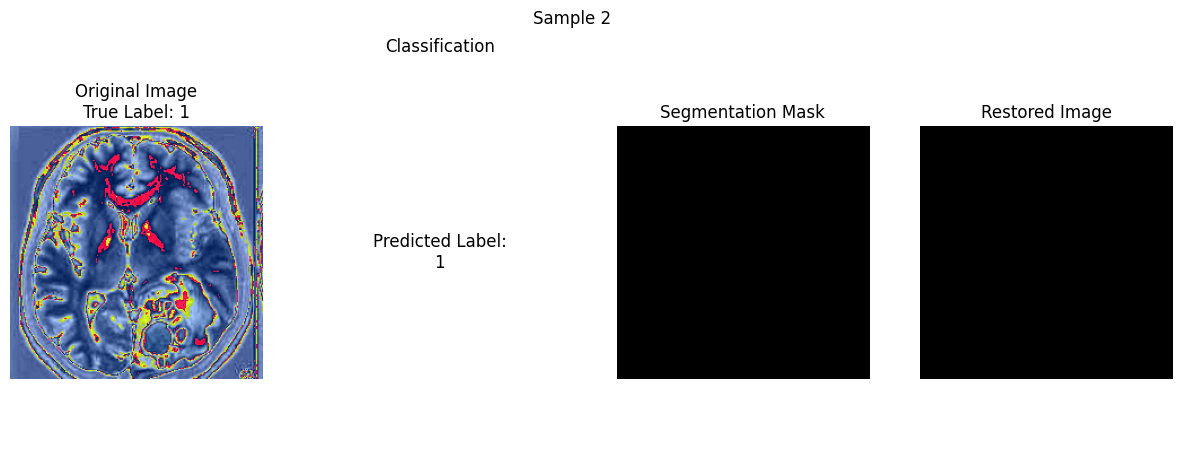

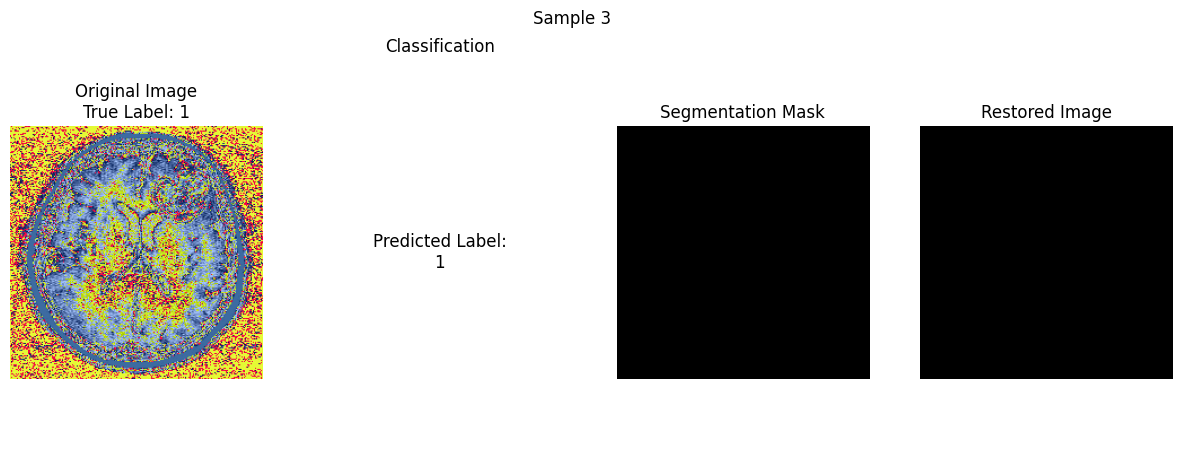

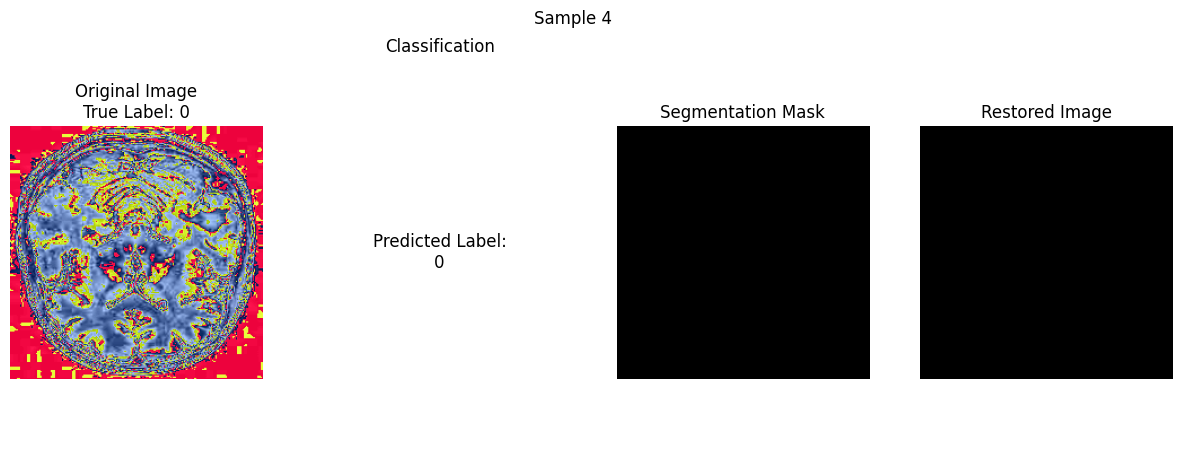

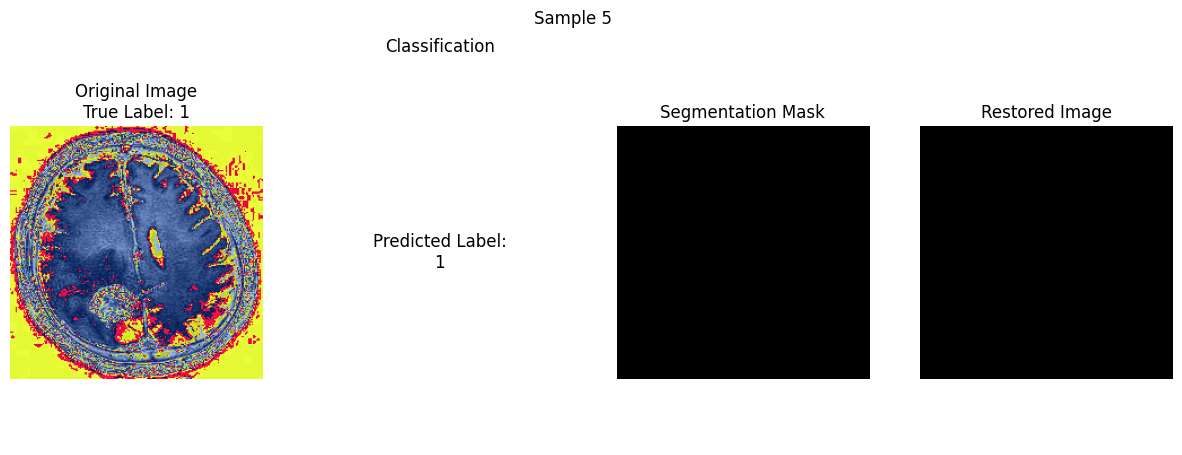

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def show_results(model, data_loader, device, num_samples=5):
    model.eval()  # Set model to evaluation mode

    sample_count = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            classification_output, segmentation_output, restoration_output = model(inputs)

            # Post-process predictions for display
            _, predicted_labels = torch.max(classification_output, 1)

            # For segmentation: apply a sigmoid and threshold for a binary mask
            segmentation_output = torch.sigmoid(segmentation_output)  # Apply sigmoid to get values between 0 and 1
            segmentation_output = (segmentation_output > 0.5).float()  # Binarize segmentation mask

            # For restoration: make sure values are in the range [0, 1] for display
            restoration_output = restoration_output.clamp(0, 1)

            # Move tensors to CPU for visualization
            inputs = inputs.cpu()
            predicted_labels = predicted_labels.cpu()
            segmentation_output = segmentation_output.cpu()
            restoration_output = restoration_output.cpu()

            # Display the results
            for i in range(inputs.size(0)):
                if sample_count >= num_samples:
                    return  # Stop once we have displayed the desired number of samples

                fig, axs = plt.subplots(1, 4, figsize=(15, 5))
                fig.suptitle(f"Sample {sample_count + 1}")

                # Original Image
                original_img = TF.to_pil_image(inputs[i])
                axs[0].imshow(original_img)
                axs[0].set_title(f"Original Image\nTrue Label: {labels[i].item()}")
                axs[0].axis('off')

                # Classification
                axs[1].text(0.5, 0.5, f"Predicted Label:\n{predicted_labels[i].item()}",
                            ha='center', va='center', fontsize=12)
                axs[1].set_title("Classification")
                axs[1].axis('off')

                # Segmentation Output
                axs[2].imshow(segmentation_output[i][0], cmap='gray')  # Show only the first channel if grayscale
                axs[2].set_title("Segmentation Mask")
                axs[2].axis('off')

                # Restoration Output
                restored_img = TF.to_pil_image(restoration_output[i])  # Convert to PIL image for display
                axs[3].imshow(restored_img)
                axs[3].set_title("Restored Image")
                axs[3].axis('off')

                plt.show()
                sample_count += 1

# Display results for 5 sample images from the validation dataset
show_results(model, val_loader, device, num_samples=5)


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Store the results for classification
all_labels = []
all_preds = []

# Store results for segmentation and restoration
segmentation_ious = []
restoration_mses = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        classification_output, segmentation_output, restoration_output = model(inputs)

        # ---- Classification Metrics ----
        # Get the predicted labels for classification
        _, preds = torch.max(classification_output, 1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # ---- Segmentation Metric (IoU) ----
        # Assuming binary mask (one-channel) for segmentation target
        # Here, we use a dummy segmentation target. Replace with actual validation targets if available.
        segmentation_target = torch.zeros_like(segmentation_output).to(device)

        # Binarize output with threshold 0.5 for IoU calculation
        segmentation_output = (segmentation_output > 0.5).float()
        intersection = (segmentation_output * segmentation_target).sum()
        union = (segmentation_output + segmentation_target - segmentation_output * segmentation_target).sum()
        iou = intersection / union if union != 0 else torch.tensor(0.0)
        segmentation_ious.append(iou.item())

        # ---- Restoration Metric (MSE) ----
restoration_target = inputs  # Original image as target for restoration

# Resize restoration_output to match restoration_target's dimensions
restoration_output = torch.nn.functional.interpolate(
    restoration_output, size=restoration_target.shape[2:], mode='bilinear', align_corners=False
)

mse = F.mse_loss(restoration_output, restoration_target)
restoration_mses.append(mse.item())

# ---- Classification Results ----
accuracy = accuracy_score(all_labels, all_preds) * 100
precision = precision_score(all_labels, all_preds, average='weighted') * 100
recall = recall_score(all_labels, all_preds, average='weighted') * 100
f1 = f1_score(all_labels, all_preds, average='weighted') * 100

print("Classification Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Sensitivity (Recall): {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# ---- Segmentation Results ----
mean_iou = sum(segmentation_ious) / len(segmentation_ious) * 100
print("\nSegmentation Results:")
print(f"Mean IoU: {mean_iou:.2f}%")

# ---- Restoration Results ----
mean_mse = sum(restoration_mses) / len(restoration_mses)
print("\nRestoration Results:")
print(f"Mean MSE: {mean_mse:.4f}")


Classification Results:
Accuracy: 82.35%
Precision: 82.92%
Sensitivity (Recall): 82.35%
F1 Score: 82.35%

Segmentation Results:
Mean IoU: 0.00%

Restoration Results:
Mean MSE: 2.0596
